# Cluster-luck: the challenge
## BIOS 26211 winter 2023

## Your Name Keegan Ballantyne

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,pairwise_distances_argmin, pairwise_distances, jaccard_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from itertools import permutations

## K-means clustering and clustering quality

https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

The basic K-means clustering algorithm can be outlined as follows:

* obtain a data set (N multi-variable observations)
* set number of clusters (k) and initial centroid positions (centers)
* initilize lables (cluster assignments)
* loop until the centers don't move
* * calculate the distance of each data point to each center
* * assign label to each data point according to the nearest centroid
* * recalculate the centroids for each cluster according to new labels
* return the centroids and the list of lables (clusters)


In [3]:
# implementation of K-means from Python Data Science Handbook
def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

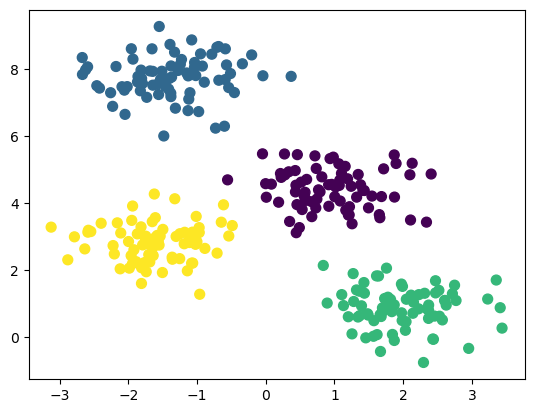

In [5]:
# generate "blobs" data set
Blobs, blob_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.6, random_state=0)

# perform K-means clustering
centers, blob_labels = find_clusters(Blobs, 4)
# plot the blobs colored by cluster label
plt.scatter(Blobs[:, 0], Blobs[:, 1], c=blob_labels,
            s=50, cmap='viridis')
plt.show()

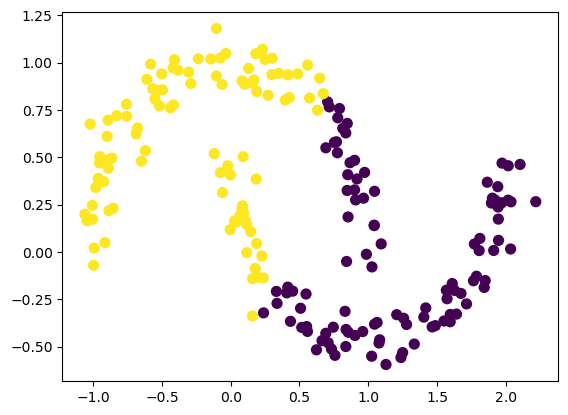

In [141]:
# generate "moons" dataset
Moons, moon_true = make_moons(200, noise=.08, random_state=10)
# perform K-means clustering on moons
centers, moon_labels = find_clusters(Moons, 2, 8)

# plot the moons colored by cluster label
plt.scatter(Moons[:, 0], Moons[:, 1], c=moon_labels,
            s=50, cmap='viridis')
plt.show()

### 1.1 Jaccard index function

Clustering quality can be evaluated using the confusion matrix and summarized using the Jaccard index, which is an improvement on the simple accuracy score (fraction of agreement between true labels and clustering labels).

Write your own function to calculate the Jaccard index and verify by comparing it with the output of jaccard_index() function from sklearn.metrics. It should do the following:

* input: array of true labels and cluster labels for a data set (check that they have the same length)

* Do: for each unique label, calculate the jaccard score as the ratio of the intersection (number of data points with the same label in both true and clustering arrays) and the union (number of data points with this label in either true or clustering arrays)

* return the mean value of the jaccard score for all the unique labels

Test your function by running it on the two lists of labels given below; the average Jaccard index should be 0.25.

In [38]:
# use np.unique
def my_jac(array1, array2): # make sure that these arrays have the same length
    """This runs and calculates the jaccard index for clustering
    array1 = true and array2 = predicted/cluster"""
    len(array1) == len(array2)
    labels = np.unique(array1)
    print(labels)
    jac = []
    for i in range(len(labels)):
        inter = np.sum((array1==labels[i])&(array2==labels[i]))
        union = np.sum((array1==labels[i])|(array2==labels[i]))
        jac.append(inter/union)
#     inter = len(list(set(array1) & set(array2)))
#     union = len(list(set(array1) | set(array2)))
    return np.mean(jac)

In [39]:
# what does set() do?
set(true_labels) & set(clust_labels)

{0, 1, 2}

In [40]:
true_labels = np.array([0,0,1,2,2,1])
clust_labels = np.array([1,0,2,1,2,2])

my_jac(true_labels, clust_labels)

[0 1 2]


0.25

### 1.2 Test on moon data

Use the moon data and the k_means clustering as generated above. One challenge for computing the prediction quality is that the predicted cluster labels may not correspond to the true labels, since the numbering of the clusters is arbitrary. 

a) Use the example in Clustering_demo notebook to rename the cluster labels before using your jaccard index function. 

b) Print out the confusion matrix, as show in the code example.

c) Run your Jaccard function on the output of Moons k-means clustering and compare the jaccard index computed with the one from the sklearn function. 


(Your answer here)

### 1.3 Test on blob data

Use the blob data and the k_means clustering as generated above. One challenge for computing the prediction quality is that the predicted cluster labels may not correspond to the true labels, since the numbering of the clusters is arbitrary. 

a) Use the example in Clustering_demo notebook to rename the cluster labels before using your jaccard index function. 

b) Print out the confusion matrix, as show in the code example.

c) Run your Jaccard function on the output of k-means clustering on blobs and compare the jaccard index computed with the one from the sklearn function. 


(Your answer here)

## Part 2: hierarchical clustering


https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Plotting-a-Dendrogram

The basic agglomerative hierarchical clustering algorithm can be outlined as follows (see the above tutorial for more detailed explanations):

* obtain a data set (N multi-variable observations) 
* initilize the linkage matrix with N rows (one for each merger) and 4 columns
* loop until all clusters have merged
* * calculate the distance between all current clusters (according to the specified distance method)
* * merge the closest pair of clusters and record it in the linkage array as a row containing: the two cluster indices, the distance betwen them, and the number of data points within this new cluster
* return the linkage matrix

The challenging issue here is keeping track of the indices of new clusters, which are added after the original data points. If there are 100 data points (indices 0 to 99), then the first merger produces cluster with index 100, next merger produces cluster with index 101, etc.

The seven methods for cluster distance used by the linkage function implemeted in scipy are described here:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

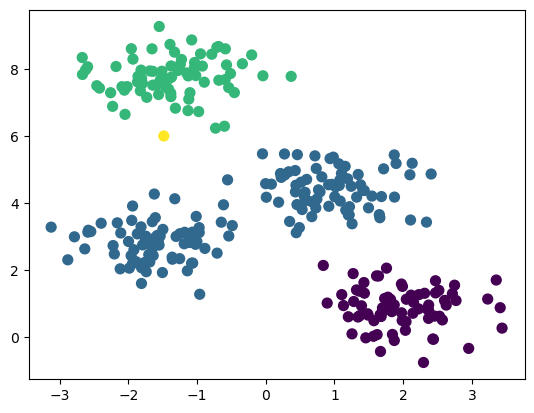

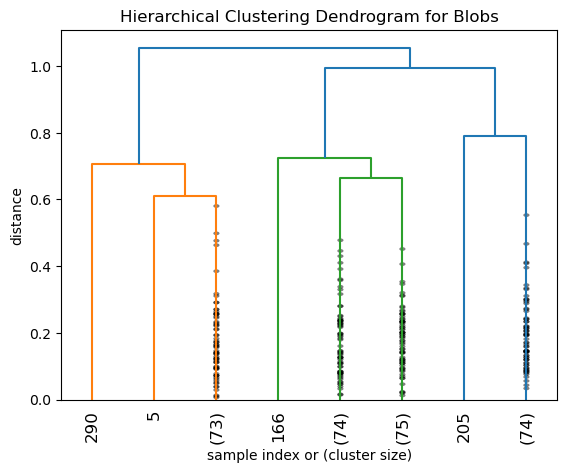

In [156]:
# generate the linkage matrix for "blobs"
Z = linkage(Blobs, 'single')

k=4
clusters=fcluster(Z, k, criterion='maxclust')
plt.scatter(Blobs[:,0], Blobs[:,1], c=clusters, s=50)  # plot points with cluster dependent colors
plt.show()


plt.title('Hierarchical Clustering Dendrogram for Blobs')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=8,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

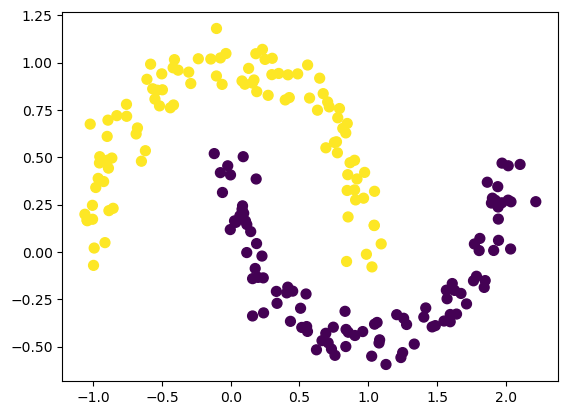

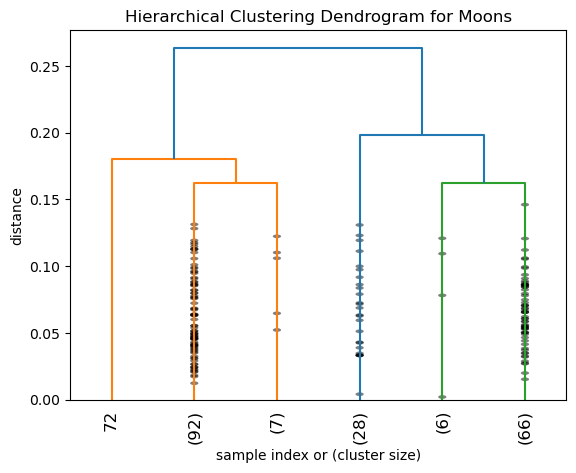

In [12]:
# generate the linkage matrix for "moons"
Z = linkage(Moons, 'single')
k=2
clusters=fcluster(Z, k, criterion='maxclust')
plt.scatter(Moons[:,0], Moons[:,1], c=clusters,s=50)  # plot points with cluster dependent colors
plt.show()

plt.title('Hierarchical Clustering Dendrogram for Moons')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=6,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

### 2.1 Implement the agglomerative clustering algorithm

Follows the outline above and implement the agglomerative hierarchical clustering with the 'single' distance metric (using the minimal distance between any two points in a pair of clusters as the distance). The function should return an array that can be used by the fcluster function to produce the dendrogram, which is a matrix that records each step of agglomeration, each containing four elements as specified below.


* Inputs: the dataset array with variables in columns and observations in rows

I suggest you define the following data structures:

* vector array of current cluster labels (starting with N, the number of observations)
* vector array of cluster labels for each observations (which will remain the size of N, the number of observations)
* matrix array of pairwise distances between clusters, initially distances between all pairs of observations (e.g. using sklearn pairwise_distances)
* matrix array of agglomeration steps, each row recording four elements: the two cluster labels, the distance between them, and the number of points in the new cluster; the array should have shape N-1 by 4.

Within the function, do the following:

1. Initialize the above arrays, then calculate the pairwise distances between all the observations and assign them to the distance matrix
2. for loop for N-1 agglomeration steps:
3. find the minimum distance in the distance matrix and assign the corresponding indices of the two nearest clusters
4. use the array of cluster labels to extract the labels for the two nearest clusters
5. assign the row of the agglomeration matrix as described above
6. update the list of cluster labels by removing the two old ones and adding the new one (the next integer, e.g. if that last label was, the new cluster will have label 67)
7. update the list of labels for observation by replacing the two old labels with one new one
8. update the pairwise distance matrix by removing the rows and columns corresponding to the old clusters and appending a new row and column for the new cluster (think carefully about indices!)

* Outuput: the agglomeration matrix with the record of each cluster merger




In [ ]:
def my_khier():
    """creates a function that runs k-hierarchal clustering"""
    # cluster label arrays
    lab_clust_origin = np.arange(0, n)
    lab_clust_current = np.arange(0, n)
    # matrix array for pairwise distances
    pairwise_array = 
    # matrix array of agglomeration steps
    agglom_array = 
    
    # for loop for the agglomeration steps
    for i in np.arange(0,100):
        
    
    sklearn.metrics.pairwise_distances(lab_clust_origin)
    return
    

### 2.2 Test on moons data

Run your hierarchical function on the moon data.

a) Make a plot of the dendrogram and compare it with the dedrogram for the moons generated above.

b) Use the example in Clustering_demo notebook to rename the cluster labels.

c) Print out the confusion matrix, as show in the code example.

d) Run your Jaccard function from part 1 on the output of Moons k-means clustering and report the agreement of the cluster labels.

(Your answer here)

### 2.3 Test on blobs data

Run your hierarchical function on the blob data.

a) Make a plot of the dendrogram and compare it with the dedrogram for the moons generated above.

b) Use the example in Clustering_demo notebook to rename the cluster labels.

c) Print out the confusion matrix, as show in the code example.

d) Run your Jaccard function from part 1 on the output of Moons k-means clustering and report the agreement of the cluster labels.

(Your answer here)

## Part 3: clustering on the Wisconsin breast cancer data set

The Wisconsin breast cancer data set contains information about different tumor biopsies in the form of 30 features of cell nuclei determined from images. The first two variables are the sample ID and the diagnosis (M = malignant or B = benign). The source and description of the data is here: https://archive-beta.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+diagnostic

The file `wdbc.csv` is loaded in the script below which also prints the names of all 32 variables in the header. Use the .iloc factor (see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#indexing-integer) to select only the variables that will be used in clustering by leaving out the first two variables and assign them to a new numpy array, and assign a new array for the diagnosis in variable index 1.


In [11]:
wisc_data = pd.read_csv("wdbc.csv")
wisc_data.head()
# np.delete()


,ID,Diagnosis,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 3.1 Clustering Wisconsin data with k-means

Use the k-means clustering algorithm on the explanatory variables arrray that you created above, and assess the quality of clustering as follows:

a) rename the generated cluster labels (0 and 1) to match the diagnostic labels (M and B). 

b) plot the confusion matrix;

c) calculate and report the Jaccard score.


### 3.2 hierarchical clustering on the Wisconsin data set 

Run your hierarchical clustering function you created above, followed by fcluster() with k=2, and assess the quality of clustering as follows:

a) plot the dendrogram with your choice of number of leaf nodes

b) rename the generated cluster labels (0 and 1) to match the diagnostic labels (M and B). 

c) plot the confusion matrix;

d) calculate and report the Jaccard score.

e) comment on which method does a better job of clustering this data


(Your answer here)